In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr
import random
import torch
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from PIL import Image
import pathlib
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import glob
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
data_dir = pathlib.Path('images/images')

In [ ]:
artist_df = pd.read_csv('artists.csv')

In [ ]:
batch_size = 32
img_height, img_width = 224, 224
artists_names= sorted(artist_df['name'].str.replace(' ', '_').tolist())

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    seed=123,
    subset='training',
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    seed=123,
    subset='validation', 
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

Found 8461 files belonging to 50 classes.
Using 6769 files for training.
Found 8461 files belonging to 50 classes.
Using 1692 files for validation.


In [ ]:
num_classes = 50
input_shape = (batch_size, img_height, img_width, 3)
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
model.add(layers.experimental.preprocessing.RandomZoom(0.1))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.build(input_shape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                      

In [ ]:
artist_df["class_weights"] = artist_df["paintings"].sum() / (artist_df.shape[0] * artist_df['paintings'])
class_weights = artist_df["class_weights"].to_dict()

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)
num_epochs = 50
start_time = time.time()
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    class_weight = class_weights,
    callbacks=[early_stop]
)
end_time = time.time()
training_time = end_time - start_time

loss, accuracy = model.evaluate(val_ds)
print(f'Validation accuracy: {accuracy}')
print(f'Validation loss: {loss:.4f}')
training_time_minutes = round(training_time / 60, 2)
print(f"Training time: {training_time_minutes} minutes")

Epoch 1/50
212/212 [==============================] - 857s 4s/step - loss: 8.9514 - accuracy: 0.0975 - val_loss: 4.9892 - val_accuracy: 0.1135
Epoch 2/50
212/212 [==============================] - 32s 146ms/step - loss: 6.6356 - accuracy: 0.1117 - val_loss: 4.2961 - val_accuracy: 0.1123
Epoch 3/50
212/212 [==============================] - 31s 144ms/step - loss: 6.1056 - accuracy: 0.1170 - val_loss: 4.1013 - val_accuracy: 0.1418
Epoch 4/50
212/212 [==============================] - 32s 145ms/step - loss: 5.7837 - accuracy: 0.1319 - val_loss: 3.8056 - val_accuracy: 0.1501
Epoch 5/50
212/212 [==============================] - 32s 147ms/step - loss: 5.5796 - accuracy: 0.1449 - val_loss: 3.8309 - val_accuracy: 0.1401
Epoch 6/50
212/212 [==============================] - 32s 148ms/step - loss: 5.4724 - accuracy: 0.1495 - val_loss: 4.0017 - val_accuracy: 0.1324
Epoch 7/50
212/212 [==============================] - 31s 144ms/step - loss: 5.3425 - accuracy: 0.1567 - val_loss: 3.9903 - val_accu

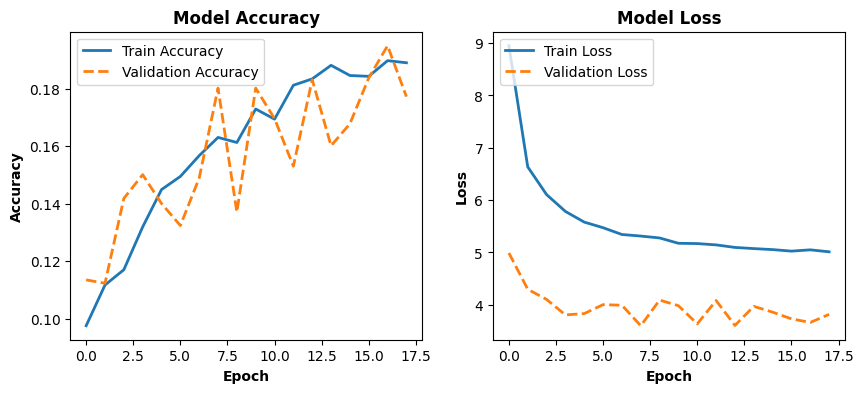

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(model_history.history['accuracy'], linestyle='-', linewidth=2, label='Train Accuracy')
ax1.plot(model_history.history['val_accuracy'], linestyle='--', linewidth=2, label='Validation Accuracy')
ax1.set_title('Model Accuracy', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_xlabel('Epoch', fontweight='bold')
ax1.legend(loc='upper left')
ax2.plot(model_history.history['loss'], linestyle='-', linewidth=2, label='Train Loss')
ax2.plot(model_history.history['val_loss'], linestyle='--', linewidth=2, label='Validation Loss')
ax2.set_title('Model Loss', fontweight='bold')
ax2.set_ylabel('Loss', fontweight='bold')
ax2.set_xlabel('Epoch', fontweight='bold')
ax2.legend(loc='upper left')
plt.show()

In [ ]:
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_class_labels = [val_ds.class_names[label] for label in val_labels]
y_pred = model.predict(val_ds) 
y_pred_classes = np.argmax(y_pred, axis=1) 
y_pred_classes = y_pred_classes.tolist()

artists_names = sorted(artist_df['name'].str.replace(' ', '_').tolist())
n_artists = len(artists_names)
artist_dict = {}
for i in range(n_artists):
    artist_dict[i] = artists_names[i]

artist_names_pred = [artist_dict[label] for label in y_pred_classes]
artist_names_true = val_class_labels

print(classification_report(artist_names_true, artist_names_pred, zero_division=0))

53/53 [==============================] - 6s 95ms/step
                           precision    recall  f1-score   support

          Albrecht_Dürer       0.00      0.00      0.00        66
           Albrecht_Dürer       0.00      0.00      0.00         0
            Alfred_Sisley       0.06      0.04      0.05        54
        Amedeo_Modigliani       0.00      0.00      0.00        39
            Andrei_Rublev       0.00      0.00      0.00        19
              Andy_Warhol       0.00      0.00      0.00        24
         Camille_Pissarro       0.00      0.00      0.00        16
               Caravaggio       0.00      0.00      0.00        15
             Claude_Monet       0.00      0.00      0.00        13
             Diego_Rivera       0.00      0.00      0.00        15
          Diego_Velazquez       0.00      0.00      0.00        22
              Edgar_Degas       0.05      0.01      0.02       157
            Edouard_Manet       0.00      0.00      0.00        26
       

In [ ]:
report = classification_report(artist_names_true, artist_names_pred, zero_division=0)

f1_scores = {}
for line in report.split('\n')[2:-5]:
    line = line.split()
    if len(line) == 0:
        continue
    class_name = line[0]
    f1_score = float(line[-1])
    f1_scores[class_name] = f1_score

top_classes = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 classes by f1-score:")
for class_name, f1_score in top_classes:
    print(class_name)

Top 5 classes by f1-score:
Vincent_van_Gogh
Edgar_Degas
Pablo_Picasso
Paul_Gauguin
Albrecht_Dürer
